In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import simulation_utils
from models import ValueIterationNetwork

# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)


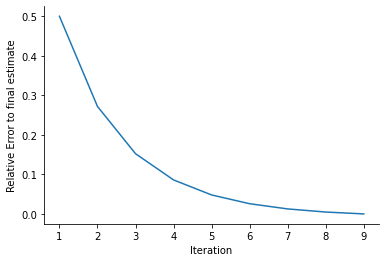

In [3]:
error = np.linalg.norm(V -  np.tile(V[-1,:], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

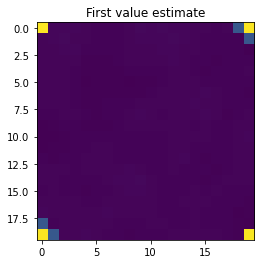

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap='viridis')
plt.title('First value estimate')
plt.savefig('2dDrift_v0.pdf', dpi=300)

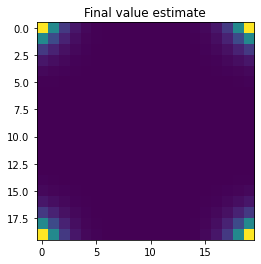

In [5]:
plt.title('Final value estimate')
plt.imshow(V[-1, :].reshape(grid_shape), cmap='viridis', vmin=0, vmax=1)
plt.savefig('2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 50

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000

# helper function
def plot_1d_value_estimates(value_estimates, gamma):
    n_steps = 7
    cc = sns.color_palette('viridis_r', n_colors=n_steps)
    for ii in range(n_steps):
        plt.plot(value_estimates[2**ii, :], label=f'{2**ii}', c=cc[ii])
    plt.plot(value_estimates[-1, :], label=f'10,000', c='k', ls='--')
    plt.ylabel('Estimated Value')
    plt.xlabel('Distance from left edge')
    plt.legend(title='Iteration')
    plt.title(r'$\gamma={}$'.format(gamma))
    sns.despine(trim=True)

def value_estimate_error(value_estimates):
    return np.linalg.norm(value_estimates[:-1:] - np.tile(value_estimates[-1,:], (iterations-1, 1)), axis=1)



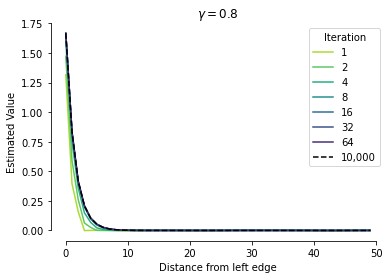

In [7]:
gamma = 0.8

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g08 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g8.pdf', dpi=300)

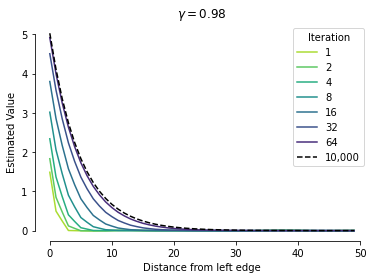

In [8]:
gamma = 0.98

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g098 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g98.pdf', dpi=300)

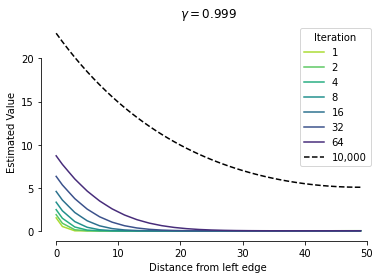

In [9]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g0999 = value_estimate_error(V)


plot_1d_value_estimates(V, gamma)
plt.savefig('1dDrift_g999.pdf', dpi=300)

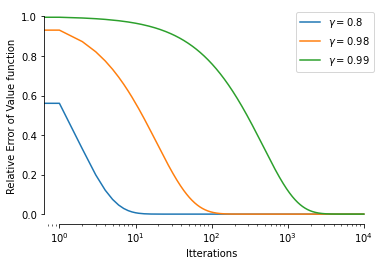

In [10]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g098/np.max(error_g098), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g0999/np.max(error_g0999), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
plt.savefig('gamma_complexity.pdf', dpi=300)



## Example 3: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


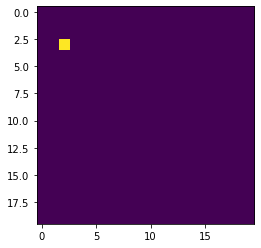

In [11]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

tiling = ValueIterationNetwork.define_lattice_tiling(n_rows, n_columns,)

# define the reward purely in terms of sucessor states
state_reward_function = np.ones(n_rows * n_columns) * -.01
gamma = 0.8
goals_state = 3 * n_columns + (n_columns // 8)
start_state = n_columns * n_rows - 1
state_reward_function[goals_state] = 1.0


# plt.figure(figsize=(8, 8))
plt.imshow(state_reward_function.reshape(n_rows, n_columns))

In [12]:
common_kwargs = dict(n_rows=n_rows, n_columns=n_columns)
transition_functions = environments.make_cardinal_transition_matrix(**common_kwargs, slip_probability=0.05)

state_action_reward_functions = [state_reward_function.copy() for _ in range(4)]

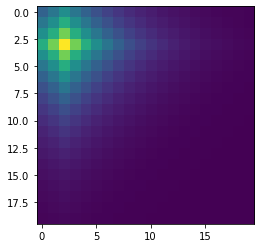

In [13]:
Q, R = ValueIterationNetwork.value_iteration(transition_functions, state_action_reward_functions, **common_kwargs, iterations=2000)
plt.imshow(R.reshape(n_rows, n_columns) )

In [14]:
np.argmax(Q, axis=1).reshape(n_rows, n_columns)

array([[3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
pi = ValueIterationNetwork.softmax(Q, beta=1000)

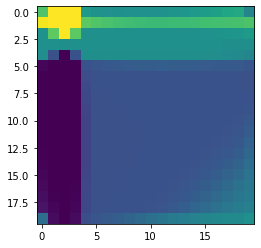

In [16]:
plt.imshow((pi[:, 3] - pi[:,0]).reshape(n_rows, n_columns))

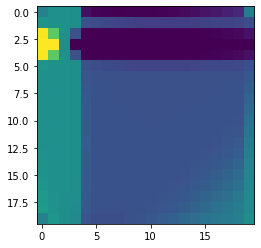

In [17]:
plt.imshow((pi[:, 2] - pi[:,1]).reshape(n_rows, n_columns))

In [18]:
trajectory = simulation_utils.sample_trajectory_until_goal(start_state, goals_state, pi, transition_functions)
len(trajectory)

68

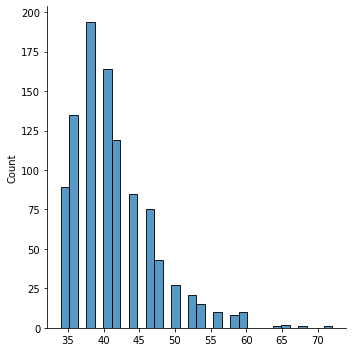

In [19]:
sns.displot(
    [len(simulation_utils.sample_trajectory_until_goal(start_state, goals_state, pi, transition_functions)) for _ in range(1000)]
)

In [20]:
goals_state
X = np.zeros_like(R)
X[goals_state] = 1
X = X.reshape((n_rows, n_columns))
r_g, c_g = np.argmax(X, axis=0).max(), np.argmax(X, axis=1).max()
d = np.abs(r_g - n_rows) + np.abs(c_g - n_columns)
print(f"Manhattan Distance from start to goal: {d}")

Manhattan Distance from start to goal: 35
